#### Reading the data 

In [48]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 

data = pd.read_csv('data/poly_mo/quant_bootstraps.tsv', header=0, sep='\t')

truth = pd.read_csv('data/poly_mo/poly_truth.tsv', header=0, index_col=0, sep='\t')

quant = pd.read_csv('data/poly_mo/quant.sf', header=0, index_col=0, sep='\t')''

Computing basic statistics for each transcript

In [49]:
data = data.apply(lambda x: np.sort(x.values))

lower_bounds = data.apply(lambda values: values[int(math.ceil(0.025*len(values)))])
upper_bounds = data.apply(lambda values: values[int(math.floor(0.975*len(values)))])
'
data_mins = data.min()'
data_maxs = data.max()
data_means = data.mean()
data_std = data.std()

data = data.transpose()

data['lower_bound'] = lower_bounds
data['upper_bound'] = upper_bounds
data['min'] = data_mins
data['max'] = data_maxs
data['mean'] = data_means
data['std'] = data_std

Merging with ground truth

In [50]:
data['truth'] = truth

data = data[~data['truth'].isnull()]

Filtering out erroneous transcripts

In [51]:
# data['erroneous'] = data.apply(
#     lambda x: (x['truth'] < x['min']) or (x['max'] < x['truth']), axis=1)


# data['erroneous'] = data.apply(
#     lambda x: ((x['mean']-(2*x['std'])) < x['truth'] ) and (x['truth'] < (x['mean']+(2*x['std']))), axis=1)


data['erroneous'] = data.apply(
    lambda x: (x['truth'] < x['lower_bound']) or (x['upper_bound'] < x['truth']), axis=1)

Percentage of rows that are erroneous:

In [52]:
print "Percentage of erroneous rows: %s" % \
    (float(sum(data['erroneous'])*100)/data.shape[0])

Percentage of erroneous rows: 50.2547510134


Assigning properties available in quant.sf file to transcripts:

In [53]:
data['Length'] = quant['Length']
data['EffectiveLength'] = quant['EffectiveLength']
data['TPM'] = quant['TPM']
data['NumReads'] = quant['NumReads']

In [54]:
from math import log

from matplotlib import pyplot as plt, rc

%matplotlib inline

Comparing distributions of properties of erroneous transcripts with non-erroneous ones

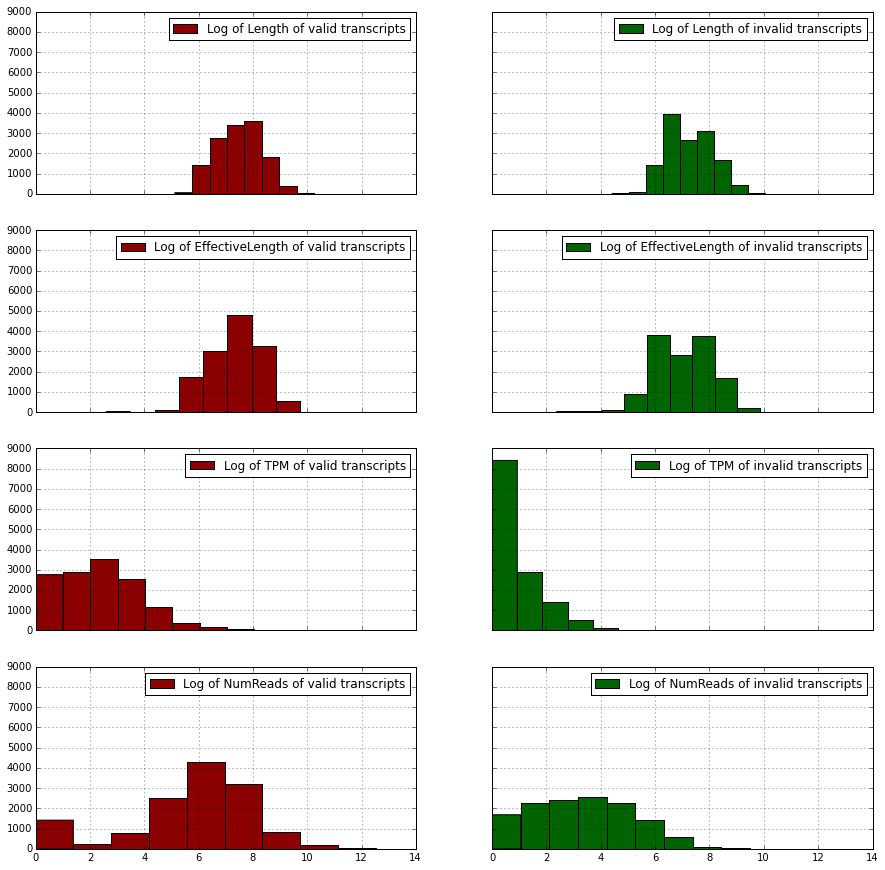

In [58]:
fig, axs = plt.subplots(4,2, sharey=True, sharex=True)
fig.set_size_inches(15,15)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

for i, prop in enumerate(properties):
    ax1 = data[data['erroneous']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i][0], color='darkred')
    ax1.legend(['Log of %s of valid transcripts' % prop])

    ax = data[~data['erroneous']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i][1], color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop])



## Equivalence Classes



Trying to look at the makeup of the equivalence classes in terms of percentage of valid and invalid transcripts:

In [70]:
invalid_ts = list(data[data['erroneous']].index)

In [71]:
lines = []
with open('data/poly_mo/eq_classes.txt') as f:
    lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

transcripts_count = int(lines[0])
data_count = int(lines[1])

transcripts = lines[2:transcripts_count+2]
classes = lines[transcripts_count+2:]

classes = [datum.split('\t') for datum in classes]

In [72]:
percentages_invalid = []

for eclass in classes:
    invalid_count = 0
    for transcript_idx in eclass[1:-1]:
        if transcripts[int(transcript_idx)] in invalid_ts:
            invalid_count += 1
    percentage_invalid = (invalid_count*100)/float(eclass[0])
    percentages_invalid.append(percentage_invalid)
        

In [88]:
percentages_valid = [100-element for element in percentages_invalid]

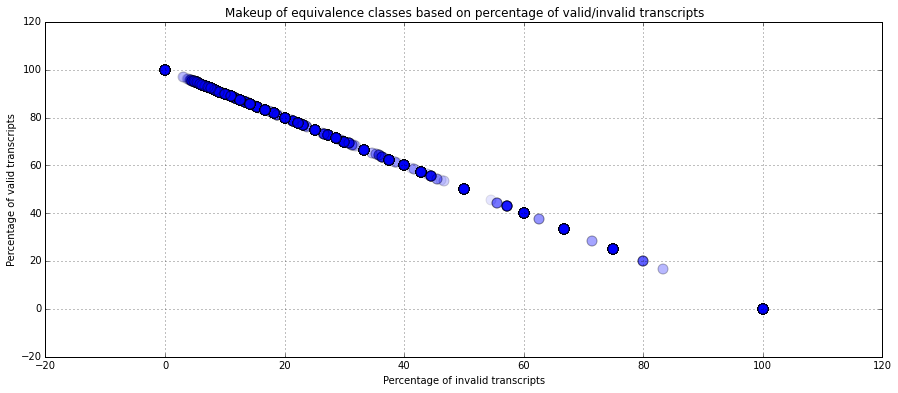

In [122]:
plt.scatter(percentages_invalid, percentages_valid, alpha=0.1, s=100)
plt.grid()
plt.xlabel('Percentage of invalid transcripts')
plt.ylabel('Percentage of valid transcripts')
plt.title("Makeup of equivalence classes based on percentage of valid/invalid transcripts")

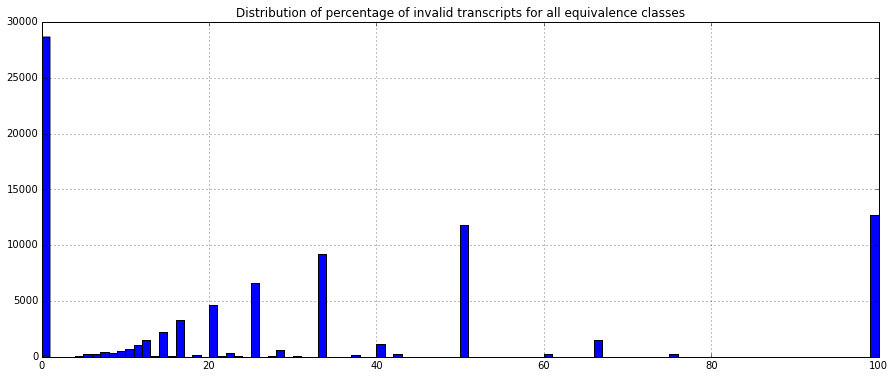

In [123]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.grid()
pd.Series(percentages_invalid).hist(bins=100)
plt.title('Distribution of percentage of invalid transcripts for all equivalence classes')

Creating a new property for each transcript: the number of equivalence classes it belongs to.

In [149]:
all_ts = [int(transcript_idx) for eclass in classes for transcript_idx in eclass[1:-1]]
ts_eclass_counts = pd.DataFrame(pd.Series(all_ts).value_counts(), columns=['eclass_cnt'])

In [151]:
transcripts = pd.DataFrame(transcripts, columns=['transcript'])
merged = pd.merge(ts_eclass_counts, transcripts, left_index=True, right_index=True)

In [158]:
merged.index = merged['transcript']; del merged['transcript']

In [160]:
data['eclass_cnt'] = merged['eclass_cnt']

In [166]:
data['eclass_cnt'] = data['eclass_cnt'].fillna(0)

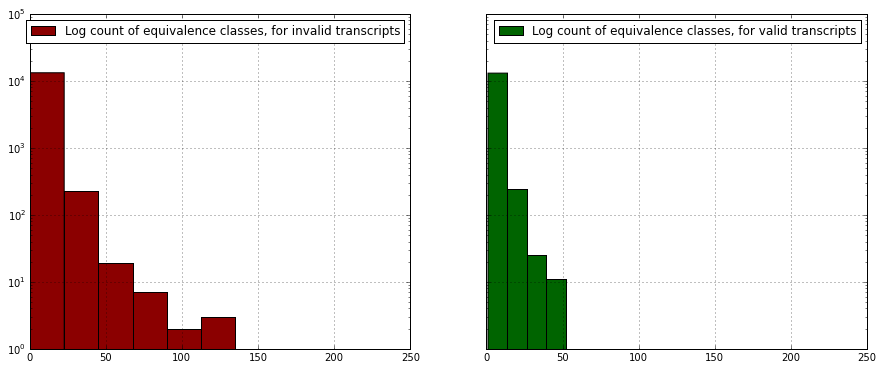

In [177]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
# fig.set_size_inches(15,15)

prop = 'eclass_cnt'

ax1 = data[data['erroneous']][prop].hist(ax=axs[0], log=True, color='darkred')#.apply(lambda x: log(x+1))
ax1.legend(['Log count of equivalence classes, for invalid transcripts'])

ax = data[~data['erroneous']][prop].hist(ax=axs[1], log=True, color='darkgreen')
ax.legend(['Log count of equivalence classes, for valid transcripts'])